### Integrantes:

- Antonio Lucas Santana Tavares - RM: 565516
- Guilherme Domingues Califoni - RM: 565157
- Rafael Silva Oliveira Nascimento - RM: 565415
- Rafael Passos de Mendonça - RM: 563075
- Lucas Mendes Moraes - RM: 563667

In [68]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (mean_squared_error, r2_score, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from statsmodels.graphics.tsaplots import plot_acf
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Pt 1
file_path = 'household_power_consumption.txt'

# Pt 2
energy_file = 'energydata_complete.csv'

# PARTE 1 – Individual Household Electric Power Consumption

In [70]:
# 1. exibindo as 10 primeiras linhas do dataset
df = pd.read_csv(file_path, sep=';', na_values='?', low_memory=False)
print(df.head(10))

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   
5  16/12/2006  17:29:00                3.520                  0.522   235.02   
6  16/12/2006  17:30:00                3.702                  0.520   235.09   
7  16/12/2006  17:31:00                3.700                  0.520   235.22   
8  16/12/2006  17:32:00                3.668                  0.510   233.99   
9  16/12/2006  17:33:00                3.662                  0.510   233.86   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1

In [71]:

# 2. Diferença entre Global_active_power e Global_reactive_power.
print("Global_active_power (Potência Ativa): É a energia real que realiza trabalho útil (ex: acender luz). Medida em kW.")
print("Global_reactive_power (Potência Reativa): É a energia usada para manter campos eletromagnéticos (ex: motores). Medida em kVAR.")

Global_active_power (Potência Ativa): É a energia real que realiza trabalho útil (ex: acender luz). Medida em kW.
Global_reactive_power (Potência Reativa): É a energia usada para manter campos eletromagnéticos (ex: motores). Medida em kVAR.


In [72]:
# 3. Verificando e quantifique valores ausentes.

missing_values = df.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_values[missing_values > 0])
# Removendo linhas com valores ausentes
df.dropna(inplace=True)
print(f"Valores ausentes removidos. Novo shape do dataset: {df.shape}")

Valores ausentes por coluna:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Valores ausentes removidos. Novo shape do dataset: (2049280, 9)


In [73]:
# 4. Convertendo colunas de data/hora e criando o dia da semana.

df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df['day_of_week'] = df['datetime'].dt.dayofweek
day_map = {0: 'Segunda', 1: 'Terça', 2: 'Quarta', 3: 'Quinta', 4: 'Sexta', 5: 'Sábado', 6: 'Domingo'}
df['day_name'] = df['day_of_week'].map(day_map)
print(df[['datetime', 'day_name']].head())

             datetime day_name
0 2006-12-16 17:24:00   Sábado
1 2006-12-16 17:25:00   Sábado
2 2006-12-16 17:26:00   Sábado
3 2006-12-16 17:27:00   Sábado
4 2006-12-16 17:28:00   Sábado


In [74]:
# 5. Filtrando por 2007 e Calculandp a média de consumo diário.

df_2007 = df[df['datetime'].dt.year == 2007].copy()
daily_avg_2007 = df_2007.groupby(df_2007['datetime'].dt.date)['Global_active_power'].mean()
print(daily_avg_2007.head())

datetime
2007-01-01    1.909031
2007-01-02    0.881414
2007-01-03    0.704204
2007-01-04    2.263481
2007-01-05    1.884281
Name: Global_active_power, dtype: float64


In [75]:
# 6. Gerando um gráfico de linha para um único dia.

single_day_df = df[df['datetime'].dt.date == pd.to_datetime('2007-01-15').date()]
plt.figure(figsize=(14, 7))
plt.plot(single_day_df['datetime'], single_day_df['Global_active_power'], label='Global Active Power')
plt.title('Consumo de Energia Ativa Global em 15/01/2007')
plt.xlabel('Hora do Dia'); plt.ylabel('Global Active Power (kilowatts)'); plt.legend()
plt.show()

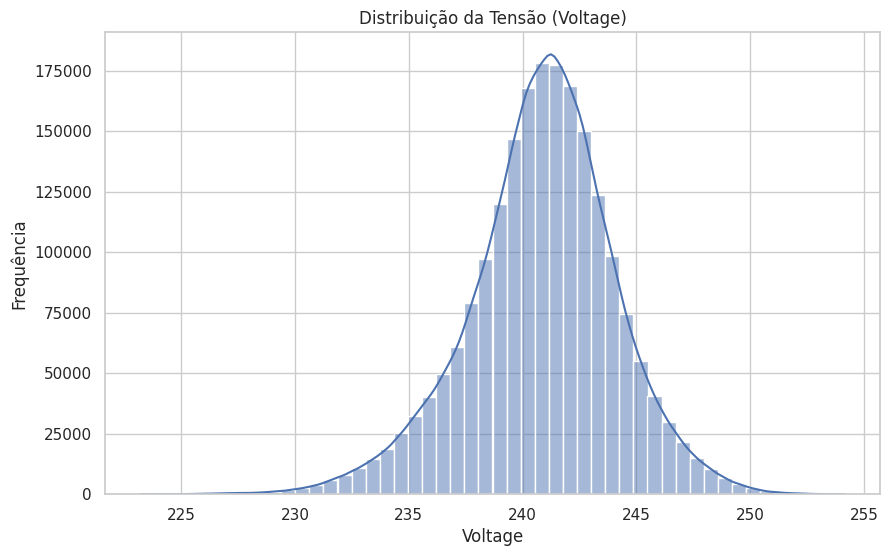

Observação: A distribuição é muito próxima de uma Normal (Gaussiana), com pico em ~240V, indicando estabilidade na rede.


In [76]:
# 7. Criando um histograma de Voltage.

plt.figure(figsize=(10, 6))
sns.histplot(df['Voltage'], kde=True, bins=50)
plt.title('Distribuição da Tensão (Voltage)')
plt.xlabel('Voltage'); plt.ylabel('Frequência')
plt.show()
print("Observação: A distribuição é muito próxima de uma Normal (Gaussiana), com pico em ~240V, indicando estabilidade na rede.")

In [77]:
# 8. Calculando o consumo médio por mês.

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
monthly_avg = df.groupby(['year', 'month'])['Global_active_power'].mean()
print(monthly_avg)

year  month
2006  12       1.901295
2007  1        1.546034
      2        1.401084
      3        1.318627
      4        0.891189
      5        0.985862
      6        0.826814
      7        0.667367
      8        0.764186
      9        0.969318
      10       1.103911
      11       1.294473
      12       1.626474
2008  1        1.459920
      2        1.181384
      3        1.245337
      4        1.115972
      5        1.024281
      6        0.994096
      7        0.794781
      8        0.276488
      9        0.987680
      10       1.136768
      11       1.387066
      12       1.275189
2009  1        1.410202
      2        1.247568
      3        1.226735
      4        1.140690
      5        1.012856
      6        0.840756
      7        0.618121
      8        0.664619
      9        0.986841
      10       1.144486
      11       1.274743
      12       1.364421
2010  1        1.430525
      2        1.375855
      3        1.130075
      4        1.027295
    

In [78]:
# 9. Identifiando o dia com maior consumo.

daily_sum = df.groupby(df['datetime'].dt.date)['Global_active_power'].sum()
max_consumption_day = daily_sum.idxmax()
print(f"O dia com maior consumo foi: {max_consumption_day} com {daily_sum.max():.2f} kilowatts.")

O dia com maior consumo foi: 2006-12-23 com 4773.39 kilowatts.


In [79]:
# 10. Comparando consumo em dias de semana vs. finais de semana.

df['is_weekend'] = df['day_of_week'].isin([5, 6])
consumption_comparison = df.groupby('is_weekend')['Global_active_power'].mean()
print(consumption_comparison)
print("Interpretação: O consumo nos finais de semana (True) tende a ser maior.")


is_weekend
False    1.035472
True     1.234232
Name: Global_active_power, dtype: float64
Interpretação: O consumo nos finais de semana (True) tende a ser maior.


In [80]:
# 11. Calculando a correlação entre variáveis.

corr_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
correlation_matrix = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

In [81]:
# 12. criando a variável Total_Sub_metering.

df['Total_Sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
print(df[['Total_Sub_metering']].head())

   Total_Sub_metering
0                18.0
1                17.0
2                19.0
3                18.0
4                18.0


In [82]:
# 13. Verifique se Total_Sub_metering ultrapassa a média de Global_active_power.

monthly_comparison = df.groupby(['year', 'month'])[['Total_Sub_metering', 'Global_active_power']].mean()
exceeds_avg = monthly_comparison[monthly_comparison['Total_Sub_metering'] > monthly_comparison['Global_active_power']]
if exceeds_avg.empty:
    print("Não houve mês em que 'Total_Sub_metering' ultrapassou 'Global_active_power'.")
else:
    print("Meses em que a condição ocorreu:", exceeds_avg)

Meses em que a condição ocorreu:             Total_Sub_metering  Global_active_power
year month                                         
2006 12              10.873181             1.901295
2007 1               10.423518             1.546034
     2                9.486135             1.401084
     3               10.212863             1.318627
     4                6.839375             0.891189
     5                8.452442             0.985862
     6                7.379151             0.826814
     7                5.697724             0.667367
     8                6.979336             0.764186
     9                8.206236             0.969318
     10               8.674493             1.103911
     11               9.819413             1.294473
     12              11.636551             1.626474
2008 1                9.786218             1.459920
     2                8.447829             1.181384
     3                9.454894             1.245337
     4                9.574745 

In [83]:
# 14. Gráfico de série temporal do Voltage para 2008.

df_2008_daily = df[df['datetime'].dt.year == 2008].set_index('datetime').resample('D')['Voltage'].mean()
plt.figure(figsize=(14, 7))
df_2008_daily.plot(title='Variação da Tensão Média Diária em 2008')
plt.xlabel('Data'); plt.ylabel('Voltage')
plt.show()

In [84]:
# 15. Comparando consumo de verão vs. inverno (Hemisfério Norte).

summer_months = [6, 7, 8]; winter_months = [12, 1, 2]
avg_summer = df[df['month'].isin(summer_months)]['Global_active_power'].mean()
avg_winter = df[df['month'].isin(winter_months)]['Global_active_power'].mean()
print(f"Consumo médio no Verão (Jun-Ago): {avg_summer:.2f} kW")
print(f"Consumo médio no Inverno (Dez-Fev): {avg_winter:.2f} kW")

Consumo médio no Verão (Jun-Ago): 0.73 kW
Consumo médio no Inverno (Dez-Fev): 1.42 kW


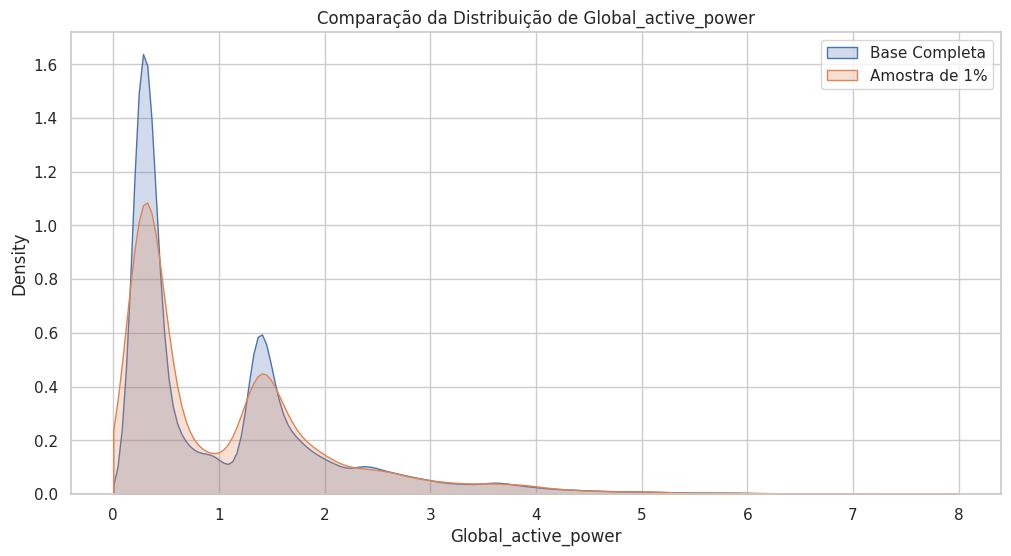

As distribuições são muito semelhantes, mostrando que a amostra é representativa.


In [85]:
# 16. Amostragem aleatória de 1%.

sample_df = df.sample(frac=0.01, random_state=42)
plt.figure(figsize=(12, 6))
sns.kdeplot(df['Global_active_power'], label='Base Completa', fill=True, clip=(0, 8))
sns.kdeplot(sample_df['Global_active_power'], label='Amostra de 1%', fill=True, clip=(0, 8))
plt.title('Comparação da Distribuição de Global_active_power')
plt.legend(); plt.show()
print("As distribuições são muito semelhantes, mostrando que a amostra é representativa.")

In [86]:
# 17. Normalização (Min-Max Scaling).

numeric_cols_main = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Total_Sub_metering']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_cols_main]), columns=numeric_cols_main, index=df.index)
print(df_scaled.head())

   Global_active_power  Global_reactive_power   Voltage  Global_intensity  \
0             0.374796               0.300719  0.376090          0.377593   
1             0.478363               0.313669  0.336995          0.473029   
2             0.479631               0.358273  0.326010          0.473029   
3             0.480898               0.361151  0.340549          0.473029   
4             0.325005               0.379856  0.403231          0.323651   

   Total_Sub_metering  
0            0.134328  
1            0.126866  
2            0.141791  
3            0.134328  
4            0.134328  


In [87]:
# --- 18. K-means para segmentar dias. ---

numeric_cols_resample = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
daily_data = df.resample('D', on='datetime')[numeric_cols_resample].mean().dropna()
features = daily_data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']]
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
daily_data['cluster'] = kmeans.fit_predict(features)
centroids = daily_data.groupby('cluster').mean()
print("Centroides dos Clusters (perfis de consumo diário):")
print(centroids[['Global_active_power', 'Global_intensity']])
print("Interpretação: Cluster 0=Baixo Consumo, Cluster 1=Alto Consumo, Cluster 2=Médio Consumo.")

Centroides dos Clusters (perfis de consumo diário):
         Global_active_power  Global_intensity
cluster                                       
0                   0.884523          3.854046
1                   0.839979          3.590786
2                   1.478511          6.208909
Interpretação: Cluster 0=Baixo Consumo, Cluster 1=Alto Consumo, Cluster 2=Médio Consumo.


In [88]:
# 19. Decomposição de série temporal.

six_months_data = daily_data['Global_active_power']['2008-01-01':'2008-06-30']
decomposition = seasonal_decompose(six_months_data, model='additive', period=7) # Sazonalidade semanal
fig = decomposition.plot()
fig.set_size_inches(14, 10); plt.show()
print("O gráfico mostra a Tendência, Sazonalidade (padrão semanal) e Resíduo.")


O gráfico mostra a Tendência, Sazonalidade (padrão semanal) e Resíduo.


In [89]:
# 20. Regressão linear simples.

X_lin = df[['Global_intensity']]; y_lin = df['Global_active_power']
X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size=0.2, random_state=42)
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
y_pred_lin = model_lin.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print(f"RMSE (Root Mean Squared Error): {rmse_lin:.4f}")
print("O erro é muito baixo, confirmando a forte relação linear entre as variáveis.")

RMSE (Root Mean Squared Error): 0.0496
O erro é muito baixo, confirmando a forte relação linear entre as variáveis.


# PARTE 2 – Exercícios Adicionais no Dataset Inicial

In [90]:
# 21. Séries temporais por hora.

df_ts = df.set_index('datetime')
hourly_data = df_ts['Global_active_power'].resample('h').mean()
hourly_avg_by_time = hourly_data.groupby(hourly_data.index.time).mean().sort_values(ascending=False)
print("Horários de maior consumo médio ao longo do dia:")
print(hourly_avg_by_time.head())

Horários de maior consumo médio ao longo do dia:
20:00:00    1.899073
21:00:00    1.876063
19:00:00    1.733428
07:00:00    1.502373
08:00:00    1.460940
Name: Global_active_power, dtype: float64


<Figure size 1400x700 with 0 Axes>

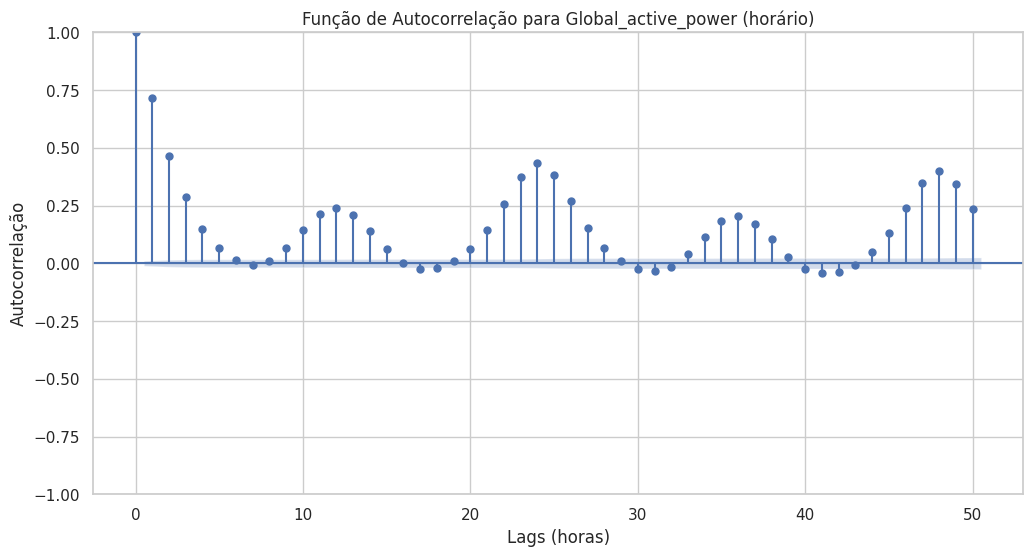

Autocorrelação com lag de 24 horas: 0.4359
Pergunta: Existem padrões repetidos diariamente? Sim, a alta autocorrelação em 24h e 48h confirma um forte padrão diário.


In [91]:
# 22. Autocorrelação do consumo.

plt.figure(figsize=(14, 7))
plot_acf(hourly_data.dropna(), lags=50)
plt.xlabel('Lags (horas)'); plt.ylabel('Autocorrelação')
plt.title('Função de Autocorrelação para Global_active_power (horário)')
plt.show()
print(f"Autocorrelação com lag de 24 horas: {hourly_data.autocorr(lag=24):.4f}")
print("Pergunta: Existem padrões repetidos diariamente? Sim, a alta autocorrelação em 24h e 48h confirma um forte padrão diário.")

In [92]:
# 23. Redução de dimensionalidade com PCA.

pca_features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
X_pca = df[pca_features]
X_pca_scaled = StandardScaler().fit_transform(X_pca)
pca = PCA(n_components=2)
pca.fit(X_pca_scaled)
print(f"Variância explicada pelos 2 componentes: {np.sum(pca.explained_variance_ratio_):.4f}")

Variância explicada pelos 2 componentes: 0.8182


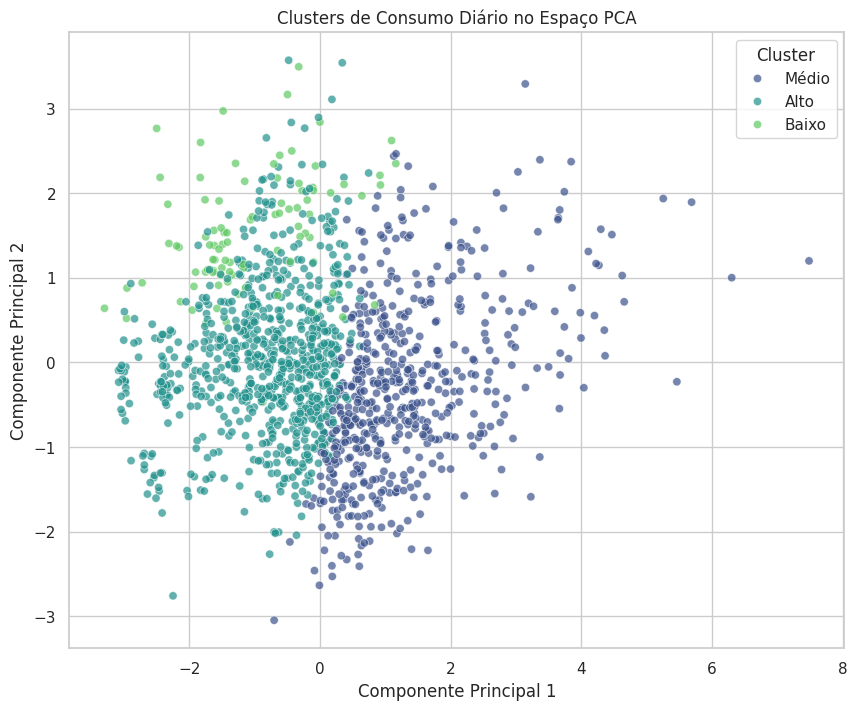

Pergunta: Os grupos se separam de forma clara? Sim, os grupos se separam bem ao longo do Componente Principal 1.


In [93]:
# 24. Visualização de clusters no espaço PCA.

daily_features_scaled = StandardScaler().fit_transform(daily_data[pca_features])
pca_daily = PCA(n_components=2)
daily_data['pca1'] = pca_daily.fit_transform(daily_features_scaled)[:, 0]
daily_data['pca2'] = pca_daily.fit_transform(daily_features_scaled)[:, 1]
daily_data['cluster_label'] = daily_data['cluster'].map({0: 'Baixo', 1: 'Alto', 2: 'Médio'})
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster_label', data=daily_data, palette='viridis', alpha=0.7)
plt.title('Clusters de Consumo Diário no Espaço PCA')
plt.xlabel('Componente Principal 1'); plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster'); plt.show()
print("Pergunta: Os grupos se separam de forma clara? Sim, os grupos se separam bem ao longo do Componente Principal 1.")

In [94]:
# 25. Regressão polinomial vs. linear.

sample_df_poly = df.sample(n=50000, random_state=42)
X_poly = sample_df_poly[['Voltage']]; y_poly = sample_df_poly['Global_active_power']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)
# Modelo Linear
linear_model_v = LinearRegression()
linear_model_v.fit(X_train_p, y_train_p)
rmse_linear_v = np.sqrt(mean_squared_error(y_test_p, linear_model_v.predict(X_test_p)))
# Modelo Polinomial
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train_p, y_train_p)
rmse_poly_v = np.sqrt(mean_squared_error(y_test_p, poly_model.predict(X_test_p)))
print(f"RMSE Regressão Linear Simples: {rmse_linear_v:.4f}")
print(f"RMSE Regressão Polinomial (Grau 2): {rmse_poly_v:.4f}")
print("Análise: O modelo polinomial tem um erro ligeiramente menor, mas ambos são ruins pois Voltage não é um bom preditor de consumo.")

RMSE Regressão Linear Simples: 0.9686
RMSE Regressão Polinomial (Grau 2): 0.9650
Análise: O modelo polinomial tem um erro ligeiramente menor, mas ambos são ruins pois Voltage não é um bom preditor de consumo.


# PARTE 3 – Novo Dataset: Appliances Energy Prediction

In [95]:
# 26. Inspecionando dTASET.

energy_df = pd.read_csv(energy_file)
print("Informações do Dataset:")
energy_df.info()
print("Estatísticas Descritivas:")
print(energy_df.describe())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non

In [96]:
# 27. Distribuição do consumo.

plt.figure(figsize=(10, 6))
sns.histplot(energy_df['Appliances'], kde=True, bins=50)
plt.title('Distribuição do Consumo de Energia (Appliances)'); plt.show()
print("Pergunta: O consumo tende a se concentrar em valores baixos ou altos? Em valores baixos, com uma longa cauda à direita (right-skewed).")

Pergunta: O consumo tende a se concentrar em valores baixos ou altos? Em valores baixos, com uma longa cauda à direita (right-skewed).


In [97]:
# 28. Correlações com variáveis ambientais.

corr_matrix_energy = energy_df.corr(numeric_only=True)
print(corr_matrix_energy['Appliances'].sort_values(ascending=False).head(10))
print("Pergunta: Quais fatores têm mais relação com o consumo? 'lights' e as temperaturas internas (T2, T6) estão entre as mais correlacionadas.")

Appliances    1.000000
lights        0.197278
T2            0.120073
T6            0.117638
T_out         0.099155
Windspeed     0.087122
RH_1          0.086031
T3            0.085060
T1            0.055447
T4            0.040281
Name: Appliances, dtype: float64
Pergunta: Quais fatores têm mais relação com o consumo? 'lights' e as temperaturas internas (T2, T6) estão entre as mais correlacionadas.


In [98]:
# 29. Normalização dos dados.

numeric_cols_energy = energy_df.select_dtypes(include=np.number).columns
scaler_energy = MinMaxScaler()
energy_df_scaled = pd.DataFrame(scaler_energy.fit_transform(energy_df[numeric_cols_energy]), columns=numeric_cols_energy)
print(energy_df_scaled.head())

   Appliances    lights       T1      RH_1        T2      RH_2        T3  \
0    0.046729  0.428571  0.32735  0.566187  0.225345  0.684038  0.215188   
1    0.046729  0.428571  0.32735  0.541326  0.225345  0.682140  0.215188   
2    0.037383  0.428571  0.32735  0.530502  0.225345  0.679445  0.215188   
3    0.037383  0.571429  0.32735  0.524080  0.225345  0.678414  0.215188   
4    0.046729  0.571429  0.32735  0.531419  0.225345  0.676727  0.215188   

       RH_3        T4      RH_4  ...        T9      RH_9     T_out  \
0  0.746066  0.351351  0.764262  ...  0.223032  0.677290  0.372990   
1  0.748871  0.351351  0.782437  ...  0.226500  0.678532  0.369239   
2  0.755569  0.344745  0.778062  ...  0.219563  0.676049  0.365488   
3  0.758685  0.341441  0.770949  ...  0.219563  0.671909  0.361736   
4  0.758685  0.341441  0.762697  ...  0.219563  0.671909  0.357985   

   Press_mm_hg    RH_out  Windspeed  Visibility  Tdewpoint       rv1       rv2  
0     0.097674  0.894737   0.500000    0.

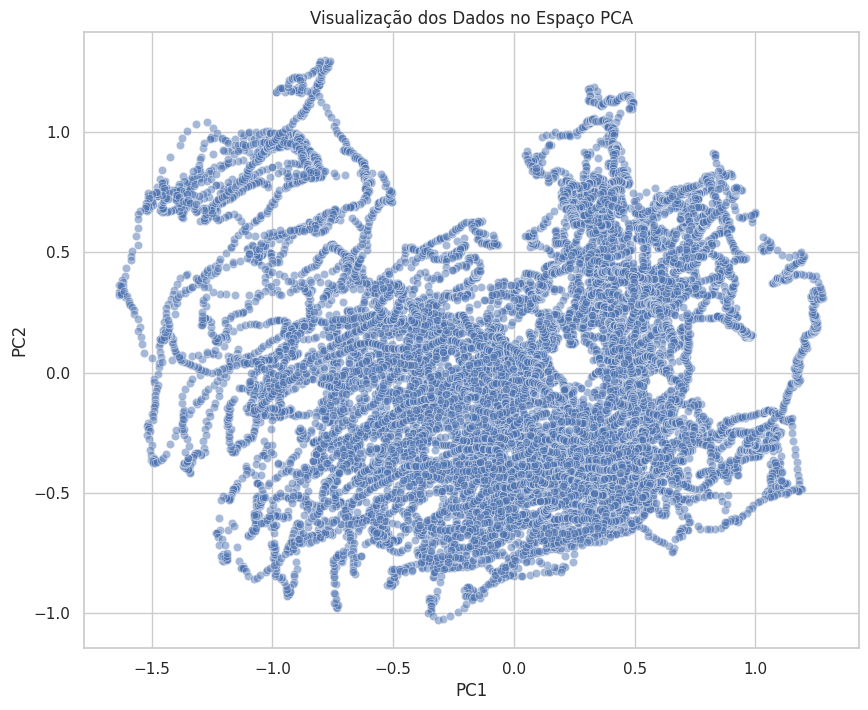

Pergunta: Aparecem padrões? Não há clusters claros, mas a estrutura dos dados é visível, com alguns padrões de densidade.


In [99]:
# 30. PCA.

pca_energy = PCA(n_components=2)
energy_pca_result = pca_energy.fit_transform(energy_df_scaled)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=energy_pca_result[:, 0], y=energy_pca_result[:, 1], alpha=0.5)
plt.title('Visualização dos Dados no Espaço PCA'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()
print("Pergunta: Aparecem padrões? Não há clusters claros, mas a estrutura dos dados é visível, com alguns padrões de densidade.")

In [100]:
# 31. Regressão Linear Múltipla.

X_e = energy_df_scaled.drop('Appliances', axis=1)
y_e = energy_df_scaled['Appliances']
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, random_state=42)
lr_multi = LinearRegression()
lr_multi.fit(X_train_e, y_train_e)
y_pred_lr = lr_multi.predict(X_test_e)
print(f"Regressão Linear Múltipla - R²: {r2_score(y_test_e, y_pred_lr):.4f}")
print(f"Regressão Linear Múltipla - RMSE: {np.sqrt(mean_squared_error(y_test_e, y_pred_lr)):.4f}")

Regressão Linear Múltipla - R²: 0.1693
Regressão Linear Múltipla - RMSE: 0.0852


In [101]:
# 32. Random Forest Regressor.

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10) # max_depth para rapidez
rf_regressor.fit(X_train_e, y_train_e)
y_pred_rf = rf_regressor.predict(X_test_e)
print(f"Random Forest Regressor - R²: {r2_score(y_test_e, y_pred_rf):.4f}")
print(f"Random Forest Regressor - RMSE: {np.sqrt(mean_squared_error(y_test_e, y_pred_rf)):.4f}")
print("Comparação: Random Forest apresenta um R² muito maior e um RMSE menor, indicando desempenho superior.")

Random Forest Regressor - R²: 0.3692
Random Forest Regressor - RMSE: 0.0743
Comparação: Random Forest apresenta um R² muito maior e um RMSE menor, indicando desempenho superior.


In [102]:
# 33. K-Means clustering.

kmeans_energy = KMeans(n_clusters=4, random_state=42, n_init=10)
energy_df_scaled['cluster'] = kmeans_energy.fit_predict(energy_df_scaled)
print("Perfis de consumo por cluster (médias normalizadas):")
print(energy_df_scaled.groupby('cluster')[['Appliances', 'T1', 'RH_1', 'lights']].mean())

Perfis de consumo por cluster (médias normalizadas):
         Appliances        T1      RH_1    lights
cluster                                          
0          0.092057  0.711229  0.398579  0.032413
1          0.077340  0.455652  0.308698  0.054024
2          0.078969  0.417400  0.463819  0.081397
3          0.078709  0.460221  0.307314  0.055545


In [103]:
# 34. Classificação binária.

median_appliances = energy_df_scaled['Appliances'].median()
energy_df_scaled['consumption_level'] = (energy_df_scaled['Appliances'] > median_appliances).astype(int)
X_clf = energy_df_scaled.drop(['Appliances', 'consumption_level', 'cluster'], axis=1)
y_clf = energy_df_scaled['consumption_level']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
# Treinando os modelos
log_reg = LogisticRegression(max_iter=1000).fit(X_train_c, y_train_c)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train_c, y_train_c)
print("Modelos de Regressão Logística e Random Forest Classifier treinados.")

Modelos de Regressão Logística e Random Forest Classifier treinados.


Métricas para Regressão Logística
Acurácia: 0.7497
Precisão: 0.7223
Recall: 0.7319
F1-Score: 0.7271


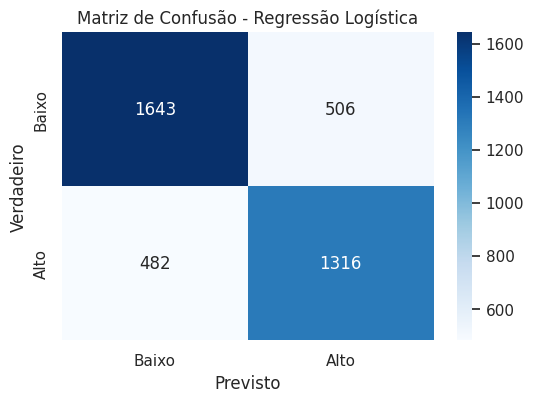

Falsos Positivos (previu Alto, era Baixo): 506
Falsos Negativos (previu Baixo, era Alto): 482
O modelo erra mais para 'Alto Consumo'.
Métricas para Random Forest Classifier
Acurácia: 0.8999
Precisão: 0.8917
Recall: 0.8882
F1-Score: 0.8899


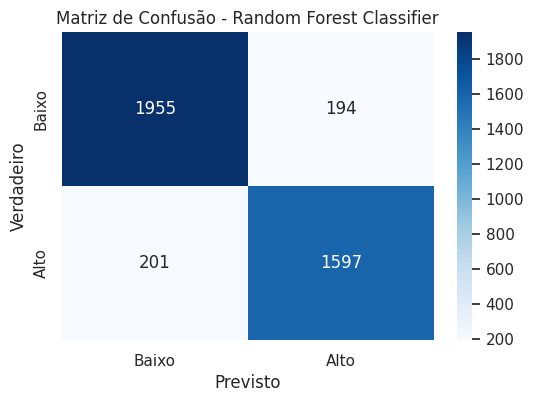

Falsos Positivos (previu Alto, era Baixo): 194
Falsos Negativos (previu Baixo, era Alto): 201
O modelo erra mais para 'Baixo Consumo'.


In [104]:
# 35. Avaliação de classificação.

def print_clf_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Métricas para {model_name}")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Alto'], yticklabels=['Baixo', 'Alto'])
    plt.xlabel('Previsto'); plt.ylabel('Verdadeiro'); plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()
    fp = cm[0, 1]; fn = cm[1, 0]
    print(f"Falsos Positivos (previu Alto, era Baixo): {fp}")
    print(f"Falsos Negativos (previu Baixo, era Alto): {fn}")
    if fp > fn:
        print("O modelo erra mais para 'Alto Consumo'.")
    else:
        print("O modelo erra mais para 'Baixo Consumo'.")

print_clf_metrics(y_test_c, log_reg.predict(X_test_c), 'Regressão Logística')
print_clf_metrics(y_test_c, rf_clf.predict(X_test_c), 'Random Forest Classifier')